In [2]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from audiomentations import Compose, TimeStretch, PitchShift, AddGaussianNoise
from tensorflow.keras.regularizers import l2

# Define paths and parameters
DATASET_PATH = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac"
LABEL_FILE_PATH = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
NUM_CLASSES = 2  # Number of classes (bonafide and spoof)
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 5  # Duration of audio clips in seconds
N_MFCC = 13  # Number of MFCC coefficients
HOP_LENGTH = 512  # Hop length for MFCC extraction
WIN_LENGTH = 1024  # Window length for MFCC extraction

labels = {}
with open(LABEL_FILE_PATH, 'r') as label_file:
    lines = label_file.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    labels[file_name] = label

X = []
y = []

max_time_steps = 109  # Define the maximum time steps for your model

for file_name, label in labels.items():
    file_path = os.path.join(DATASET_PATH, file_name + ".flac")

    # Load audio file using librosa
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Extract MFCC features using librosa
    mfcc = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, n_fft=WIN_LENGTH)

    # Ensure all MFCC features have the same width (time steps)
    if mfcc.shape[1] < max_time_steps:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_time_steps - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_time_steps]

    X.append(mfcc)
    y.append(label)

X = np.array(X)
y = np.array(y)

2023-10-16 13:48:27.449545: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 13:48:27.574480: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-16 13:48:27.574502: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-16 13:48:27.596967: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-16 13:48:28.074354: W tensorflow/stream_executor/pla

In [3]:
from sklearn.model_selection import train_test_split

# Data augmentation using audiomentations
augment = Compose([
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
])

X_augmented = [augment(samples=x, sample_rate=SAMPLE_RATE) for x in X]

# Split the data into training (80%) and the rest (20%)
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the rest into validation (50%) and test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

/home/sae/ENTER/envs/newconda/lib/python3.9/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=109
  warnings.warn(


In [23]:
from sklearn.utils.class_weight import compute_class_weight


# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert the class weights to a dictionary
class_weight_dict = {i: class_weights[i] for i in range(NUM_CLASSES)}

In [26]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()

# Reshape the 3D data to 2D
X_train_2d = X_train.reshape(-1, X_train.shape[-1])
X_val_2d = X_val.reshape(-1, X_val.shape[-1])
X_test_2d = X_test.reshape(-1, X_test.shape[-1])

# Fit the scaler to your training data and transform it
X_train_normalized = scaler.fit_transform(X_train_2d)

# Transform the validation and test data using the same scaler
X_val_normalized = scaler.transform(X_val_2d)
X_test_normalized = scaler.transform(X_test_2d)

# Reshape the normalized data back to 3D
X_train_normalized = X_train_normalized.reshape(X_train.shape)
X_val_normalized = X_val_normalized.reshape(X_val.shape)
X_test_normalized = X_test_normalized.reshape(X_test.shape)

In [45]:
#final pick
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 5, min_lr = 0.00001)

# Define and compile a CNN model with L2 regularization and other improvements
model = tf.keras.Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(N_MFCC, max_time_steps, 1),
           kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.8),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using class weights
history = model.fit(np.expand_dims(X_train_normalized, -1), y_train, batch_size=32, epochs=20,
                validation_data=(np.expand_dims(X_val_normalized, -1), y_val), class_weight=class_weight_dict, callbacks = [reduce_lr])
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(np.expand_dims(X_test_normalized, -1), y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


# Make predictions on the testing set
y_test_pred = model.predict(X_test)


Epoch 1/20
635/635 [==============================] - 16s 24ms/step - loss: 1.7223 - accuracy: 0.7759 - val_loss: 0.7325 - val_accuracy: 0.9630 - lr: 0.0010
Epoch 2/20
635/635 [==============================] - 15s 24ms/step - loss: 0.6841 - accuracy: 0.8935 - val_loss: 0.9759 - val_accuracy: 0.7206 - lr: 0.0010
Epoch 3/20
635/635 [==============================] - 15s 24ms/step - loss: 0.5503 - accuracy: 0.9050 - val_loss: 0.4049 - val_accuracy: 0.9634 - lr: 0.0010
Epoch 4/20
635/635 [==============================] - 15s 24ms/step - loss: 0.5068 - accuracy: 0.9148 - val_loss: 0.3756 - val_accuracy: 0.9768 - lr: 0.0010
Epoch 5/20
635/635 [==============================] - 15s 24ms/step - loss: 0.4623 - accuracy: 0.9234 - val_loss: 0.3263 - val_accuracy: 0.9586 - lr: 0.0010
Epoch 6/20
635/635 [==============================] - 15s 24ms/step - loss: 0.4146 - accuracy: 0.9265 - val_loss: 0.4698 - val_accuracy: 0.9050 - lr: 0.0010
Epoch 7/20
635/635 [==============================] - 15s 

In [39]:
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_test_pred_thresholded = (y_test_pred > 0.9).astype(int)


Test Loss: 0.2710050642490387
Test Accuracy: 0.9645389914512634


In [29]:
#epoch experiment
from sklearn.utils import shuffle
# Shuffle the training data
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Shuffle the validation data (if needed)
X_validation, y_validation = shuffle(X_val, y_val, random_state=42)

# Shuffle the test data
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# Train the model
num_epochs = [5, 7, 9, 10,11,13,15]
num_batch_size = 32 #number of features to train at once

#Find the best epoch
for epoch in num_epochs:

    # Define and compile a CNN model with L2 regularization and other improvements
    model = tf.keras.Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(N_MFCC, max_time_steps, 1),
            kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Train the model using class weights
    history = model.fit(np.expand_dims(X_train, -1), y_train, batch_size=num_batch_size, epochs=epoch,
                    validation_data=(np.expand_dims(X_val, -1), y_val), class_weight=class_weight_dict)
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(np.expand_dims(X_test, -1), y_test)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")



Epoch 1/5
635/635 [==============================] - 10s 15ms/step - loss: 2.3396 - accuracy: 0.8350 - val_loss: 1.2712 - val_accuracy: 0.8924
Epoch 2/5
635/635 [==============================] - 9s 15ms/step - loss: 1.0501 - accuracy: 0.8788 - val_loss: 0.8246 - val_accuracy: 0.8920
Epoch 3/5
635/635 [==============================] - 10s 15ms/step - loss: 0.6944 - accuracy: 0.9064 - val_loss: 0.5629 - val_accuracy: 0.9370
Epoch 4/5
635/635 [==============================] - 10s 15ms/step - loss: 0.4819 - accuracy: 0.9306 - val_loss: 0.3914 - val_accuracy: 0.9444
Epoch 5/5
80/80 [==============================] - 0s 5ms/step - loss: 0.5448 - accuracy: 0.8664
Test Loss: 0.5448422431945801
Test Accuracy: 0.8664302825927734
Epoch 1/7
635/635 [==============================] - 10s 15ms/step - loss: 1.9835 - accuracy: 0.8247 - val_loss: 1.0394 - val_accuracy: 0.9043
Epoch 2/7
635/635 [==============================] - 10s 15ms/step - loss: 0.8825 - accuracy: 0.8755 - val_loss: 0.6136 - val

Epoch vs acurracy (without feature and batch normalization)

Epoch 5
Test Loss: 0.5448422431945801
Test Accuracy: 0.8664302825927734

Epoch 7
Test Loss: 0.19813142716884613
Test Accuracy: 0.9669030904769897

Epcoh 9
Test Loss: 0.19333580136299133
Test Accuracy: 0.9712371826171875

Epoch 10
Test Loss: 0.17238442599773407
Test Accuracy: 0.9724192023277283

Epoch 11
Test Loss: 0.18624095618724823
Test Accuracy: 0.9672970771789551

Epoch 13
Test Loss: 0.2408178448677063
Test Accuracy: 0.9338061213493347

Epoch 15
Test Loss: 0.19771648943424225
Test Accuracy: 0.9456264972686768

In [8]:
y_test_pred_thresholded = (y_test_pred > 0.9).astype(int)

In [19]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.utils import shuffle


k = 10 # 10 fold validation
cv = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42)

#Combine training, validation, and testing data
X_combined = np.concatenate((X_train, X_val))
y_combined = np.concatenate((y_train, y_val))
X_combined, y_combined = shuffle(X_combined, y_combined, random_state = 42)
print(len(X_combined))
print(len(y_combined))

#Store accuracy
results = []

#Store training and validation indices for each fold
train_indices = []
validation_indices = []

#split the data into k folds
for train_idx, val_idx in cv.split(X_combined, y_combined):
    train_indices.append(train_idx)
    validation_indices.append(val_idx)
    
#Perform k-fold cross-validation
for fold in range(k):
    train_idx = train_indices[fold]
    val_idx = validation_indices[fold]
    
    X_train_fold, y_train_fold = X_combined[train_idx], y_combined[train_idx]
    X_val_fold, y_val_fold = X_combined[val_idx], y_combined[val_idx]
    print("X_train_fold shape:", X_train_fold.shape)
    print("y_train_fold shape:", y_train_fold.shape)

    
    # y_train_encoded = to_categorical(le.fit_transform(y_train_fold))
    # y_validation_encoded = to_categorical(le.transform(y_val_fold))
    # print("X_train_fold shape:", X_train_fold.shape)
    # print("y_train_encoded shape:", y_train_encoded.shape)

   # Define and compile a CNN model with L2 regularization and other improvements
    model = tf.keras.Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(N_MFCC, max_time_steps, 1),
            kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Train the model using class weights
    history = model.fit(np.expand_dims(X_train_fold, -1), y_train_fold, batch_size=32, epochs=10,
                    validation_data=(np.expand_dims(X_val_fold, -1), y_val_fold), class_weight=class_weight_dict)
    


    # Make predictions on the testing set
    y_test_pred = model.predict(X_test)
    y_test_pred_thresholded = (y_test_pred > 0.9).astype(int)

    # Calculate accuracy for this fold
    fold_accuracy = accuracy_score(y_test, y_test_pred_thresholded)
    results.append(fold_accuracy)

# Calculate mean and standard deviation of accuracy scores
mean_accuracy = np.mean(results)
std_accuracy = np.std(results)


22842
22842
X_train_fold shape: (20557, 13, 109)
y_train_fold shape: (20557,)
Epoch 1/10
643/643 [==============================] - 6s 9ms/step - loss: 1.8626 - accuracy: 0.8300 - val_loss: 1.1709 - val_accuracy: 0.8083
Epoch 2/10
643/643 [==============================] - 6s 9ms/step - loss: 0.7492 - accuracy: 0.8818 - val_loss: 0.5604 - val_accuracy: 0.9208
Epoch 3/10
643/643 [==============================] - 7s 11ms/step - loss: 0.5288 - accuracy: 0.8948 - val_loss: 0.3788 - val_accuracy: 0.9427
Epoch 4/10
643/643 [==============================] - 6s 9ms/step - loss: 0.3788 - accuracy: 0.9239 - val_loss: 0.3242 - val_accuracy: 0.9606
Epoch 5/10
643/643 [==============================] - 5s 9ms/step - loss: 0.3099 - accuracy: 0.9430 - val_loss: 0.2281 - val_accuracy: 0.9698
Epoch 6/10
643/643 [==============================] - 7s 11ms/step - loss: 0.2805 - accuracy: 0.9433 - val_loss: 0.2415 - val_accuracy: 0.9545
Epoch 7/10
643/643 [==============================] - 7s 10ms/step -

In [20]:
#Print results from k fold cross validation

for i in range(k):
    print("Fold: ", i + 1, " Accuracy: ", results[i])

print("Mean acuracy: ", mean_accuracy)

#Use this to compare performance across different models

Fold:  1  Accuracy:  0.9743892828999212
Fold:  2  Accuracy:  0.9657210401891253
Fold:  3  Accuracy:  0.9747832939322301
Fold:  4  Accuracy:  0.9684791174152876
Fold:  5  Accuracy:  0.9755713159968479
Fold:  6  Accuracy:  0.9377462568951931
Fold:  7  Accuracy:  0.9724192277383766
Fold:  8  Accuracy:  0.9700551615445232
Fold:  9  Accuracy:  0.9613869188337274
Fold:  10  Accuracy:  0.9716312056737588
Mean acuracy:  0.9672182821118991


Fold:  1  Accuracy:  0.9743892828999212
Fold:  2  Accuracy:  0.9657210401891253
Fold:  3  Accuracy:  0.9747832939322301
Fold:  4  Accuracy:  0.9684791174152876
Fold:  5  Accuracy:  0.9755713159968479
Fold:  6  Accuracy:  0.9377462568951931
Fold:  7  Accuracy:  0.9724192277383766
Fold:  8  Accuracy:  0.9700551615445232
Fold:  9  Accuracy:  0.9613869188337274
Fold:  10  Accuracy:  0.9716312056737588
Mean acuracy:  0.9672182821118991

In [10]:
#precision/recall calculation - use 0.7 threshold for now, do not run this code unless we want to test out recall/precision
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

#Store accuracy and precision/recall
fold_precisions = []
fold_recalls = []

#F1 scores
fold_f1_scores = []
fold_half_scores = []
fold_double_scores = []

import numpy as np
# Initialize an array of threshold values (e.g., from 0.1 to 0.9)
thresholds = np.arange(0.1, 1.0, 0.1)

#save confusion matrix
fold_cm = []

# le = LabelEncoder()
# num_epochs = 3
# num_batch_size = 32

# Train the model

# le = LabelEncoder()
# y_train_encoded = to_categorical(le.fit_transform(y_train))
# y_validation_encoded = to_categorical(le.transform(y_validation))
# y_test_encoded = to_categorical(le.transform(y_test))


for threshold in thresholds:
    y_test_pred_thresholded = (y_test_pred > threshold).astype(int)  # Adjust the column index if needed
    
    
    cm = confusion_matrix(y_test, y_test_pred_thresholded)
    FP = cm[0, 1]  # False Positives
    FN = cm[1, 0]  # False Negatives
    
    print("FP: ", FP, " FN: ", FN)
    print(cm)

    # Calculate TP, FP, FN for the current threshold
    precision = precision_score(y_test, y_test_pred_thresholded)
    recall = recall_score(y_test, y_test_pred_thresholded) 

    # Calculate F1 score using precision and recall
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    fhalf = (1 + 0.5**2) * (precision * recall) / (0.5**2 * precision + recall) if (precision + recall) > 0 else 0
    fdouble = (1 + 2**2) * (precision * recall) / (2**2 * precision + recall) if (precision + recall) > 0 else 0
    
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_cm.append(cm)
    fold_f1_scores.append(f1)
    fold_half_scores.append(fhalf)
    fold_double_scores.append(fdouble)

FP:  398  FN:  1
[[1894  398]
 [   1  245]]
FP:  297  FN:  2
[[1995  297]
 [   2  244]]
FP:  229  FN:  2
[[2063  229]
 [   2  244]]
FP:  191  FN:  6
[[2101  191]
 [   6  240]]
FP:  153  FN:  7
[[2139  153]
 [   7  239]]
FP:  121  FN:  13
[[2171  121]
 [  13  233]]
FP:  87  FN:  18
[[2205   87]
 [  18  228]]
FP:  59  FN:  23
[[2233   59]
 [  23  223]]
FP:  30  FN:  38
[[2262   30]
 [  38  208]]


Fold 0.1   Precision:  0.3810264385692068   Recall:  0.9959349593495935
F1 Score:  0.5511811023622047 F-0.5 Score:  0.4347054648687012 F-2 Score:  [0.7529194837123541, 0.7999999999999999, 0.8373369938229238, 0.8480565371024735, 0.8684593023255814, 0.8707025411061284, 0.8775981524249424, 0.8807266982622433, 0.851063829787234]

Fold 0.2   Precision:  0.4510166358595194   Recall:  0.991869918699187
F1 Score:  0.6200762388818297 F-0.5 Score:  0.5062240663900415 F-2 Score:  [0.7529194837123541, 0.7999999999999999, 0.8373369938229238, 0.8480565371024735, 0.8684593023255814, 0.8707025411061284, 0.8775981524249424, 0.8807266982622433, 0.851063829787234]

Fold 0.30000000000000004   Precision:  0.5158562367864693   Recall:  0.991869918699187
F1 Score:  0.6787204450625869 F-0.5 Score:  0.5706267539756782 F-2 Score:  [0.7529194837123541, 0.7999999999999999, 0.8373369938229238, 0.8480565371024735, 0.8684593023255814, 0.8707025411061284, 0.8775981524249424, 0.8807266982622433, 0.851063829787234]

Fo

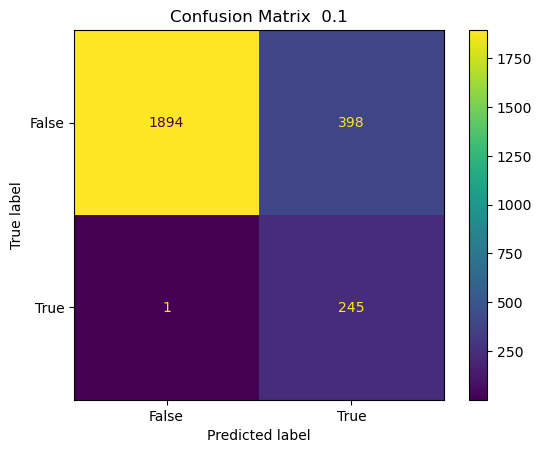

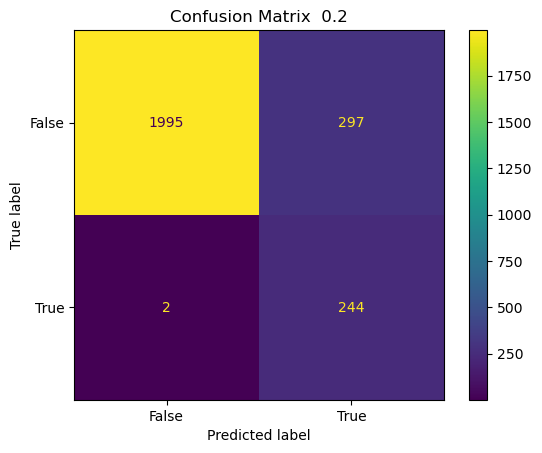

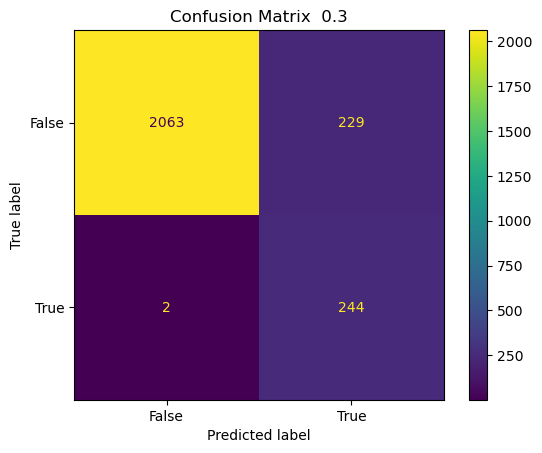

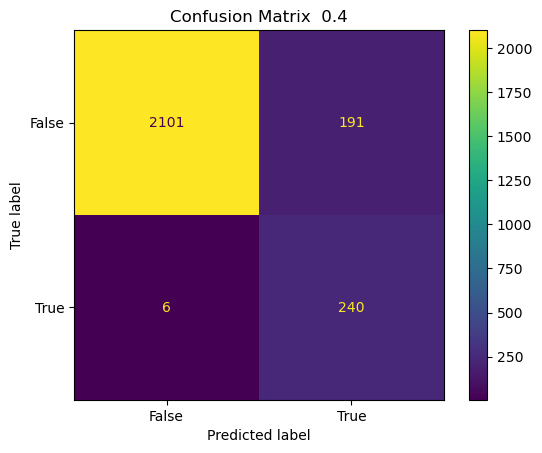

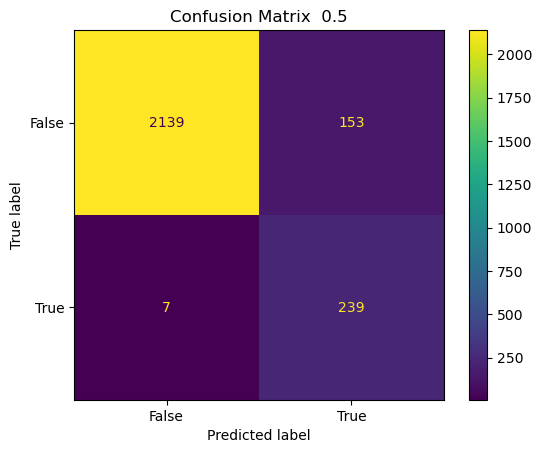

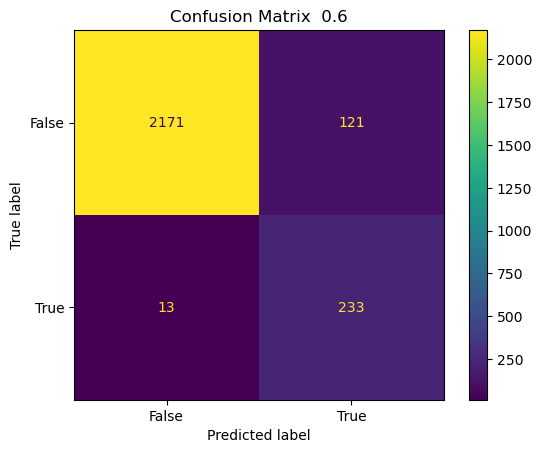

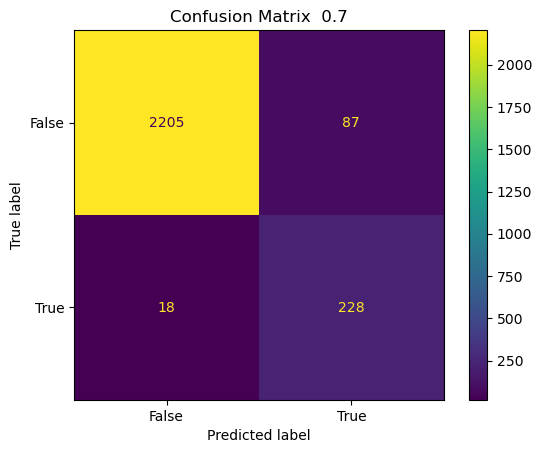

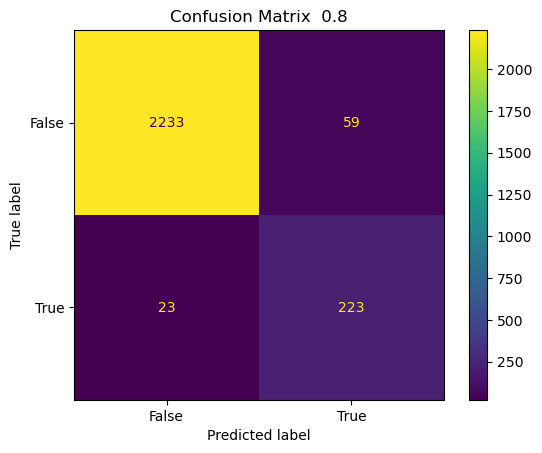

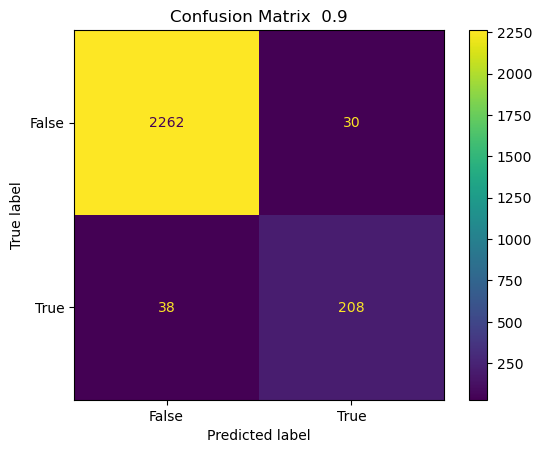

In [11]:
import matplotlib.pyplot as plt
# Calculate mean F1 scores over all folds
mean_f1_scores = np.mean(fold_f1_scores, axis=0)
mean_fhalf_scores = np.mean(fold_half_scores, axis=0)
mean_fdouble_scores = np.mean(fold_double_scores, axis=0)
mean_recall = np.mean(fold_recalls, axis=0)
mean_precision = np.mean(fold_precisions, axis=0)

for i in range(len(thresholds)):
     print("Fold", i*0.1+0.1, "  Precision: ", fold_precisions[i], "  Recall: ", fold_recalls[i])
     print("F1 Score: ", fold_f1_scores[i], "F-0.5 Score: ", fold_half_scores[i], "F-2 Score: ", fold_double_scores)
     print()

print("  Mean precision: ", mean_precision, "  Mean recall: ", mean_recall)
print(" Mean F1 Score: ", mean_f1_scores)
print(" Mean F-0.5 Score: ", mean_fhalf_scores)
print(" Mean F-0.5 Score: ", mean_fdouble_scores)


#Print confusion matrix
import matplotlib.pyplot as metrics
from sklearn.metrics import ConfusionMatrixDisplay

for i in range(len(fold_cm)):
    cm_display = ConfusionMatrixDisplay(confusion_matrix = fold_cm[i], display_labels = [False, True])
    cm_display.plot()
    title = i * 0.1+0.1
     
    plt.title(f'Confusion Matrix {title: .1f}')
    plt.show()
    
    
#pick 0.9 as threshold for now, but we might have to priotize recalls moving on

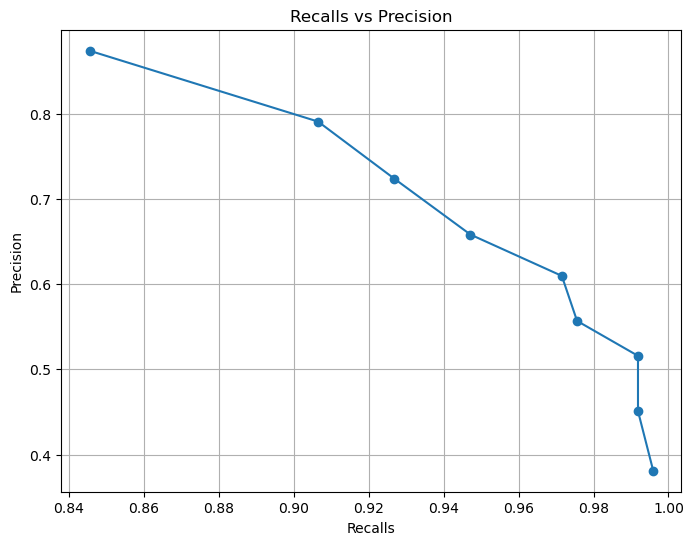

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(fold_recalls, fold_precisions, marker='o', linestyle='-')
plt.xlabel('Recalls')
plt.ylabel('Precision')
plt.title('Recalls vs Precision')
plt.grid(True)
plt.show()

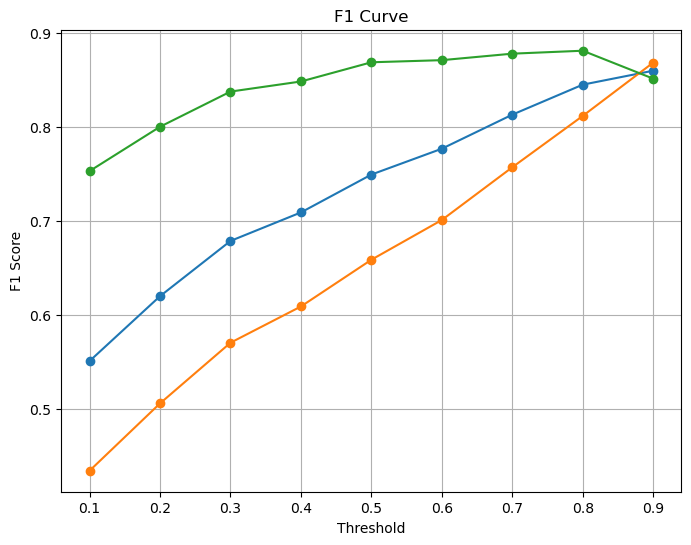

Mean F1 Score: 0.7335


In [15]:
#Plot the F1 curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, fold_f1_scores, marker='o', linestyle='-')
plt.plot(thresholds, fold_half_scores, marker='o', linestyle='-')
plt.plot(thresholds, fold_double_scores, marker='o', linestyle='-')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Curve')
plt.grid(True)
plt.show()

# Display the mean F1 score
print(f"Mean F1 Score: {mean_f1_scores:.4f}")

#pick 0.7 threshold

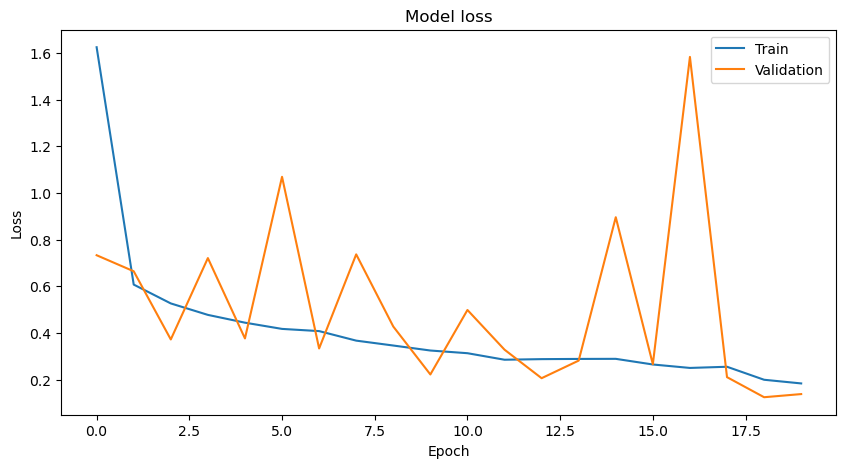

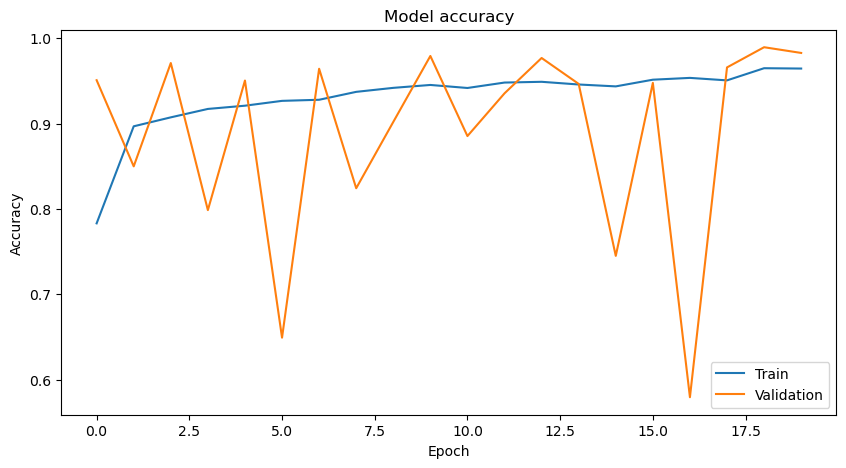

In [43]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [13]:
# Evaluate the model on the pseudo-test set
pseudo_test_loss, pseudo_test_accuracy = model.evaluate(np.expand_dims(X_val, -1), y_val)
print(f"Pseudo Test Loss: {pseudo_test_loss}")
print(f"Pseudo Test Accuracy: {pseudo_test_accuracy}")

80/80 [==============================] - 0s 5ms/step - loss: 0.2313 - accuracy: 0.9476
Pseudo Test Loss: 0.23131117224693298
Pseudo Test Accuracy: 0.947596549987793
